     Num  Feature  correct_mean
0      1   colour      2.513147
1      1     high      1.827110
2      1      low      2.124727
3      1    shape      2.378713
4      1     size      2.544812
..   ...      ...           ...
115   20     high      2.032223
116   20      low      2.165103
117   20    shape      2.522925
118   20     size      2.774920
119   20  texture      2.855665

[120 rows x 3 columns]
{('colour', 'high'): [np.float64(0.6860362384358973), np.float64(1.0244466631826927), np.float64(0.9915115662076919), np.float64(0.6206344355142859), np.float64(0.9534590124017097), np.float64(1.0376721407607141), np.float64(1.3018034124835165), np.float64(1.0076761520993593), np.float64(0.7465624961666666), np.float64(0.8264792429839745), np.float64(0.5372408865000002), np.float64(1.2310742538791208), np.float64(0.9512547319670333), np.float64(0.26838526884375025), np.float64(1.0006863313749998), np.float64(0.6162879710897435), np.float64(0.7310724437249998), np.float64(0.887938662625

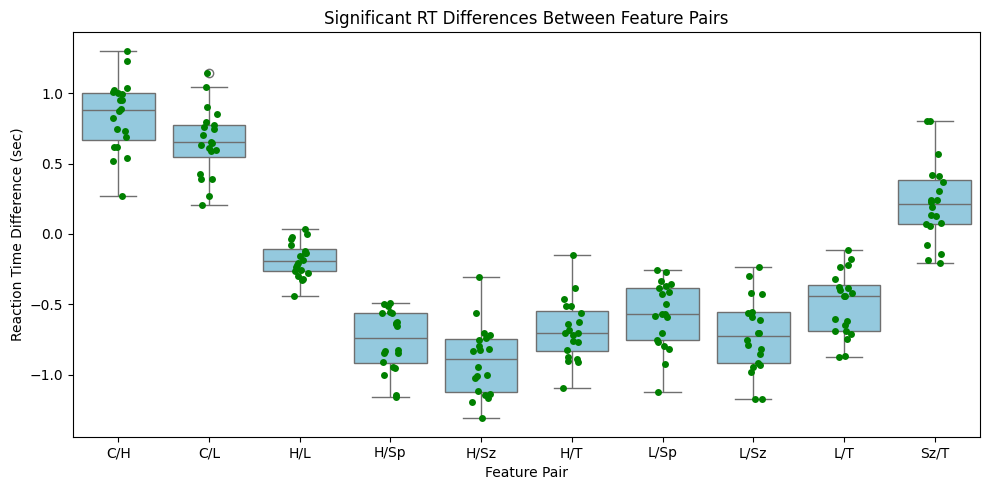

In [ ]:
import pandas as pd

#Read the CSV files for participants 1 to 20 and append their data to a list
pt_data = []

for num in range(1, 21):
    data = f'sample_data/Par{num:02d}.csv'
    rd_data = pd.read_csv(data)
    rd_data['Num'] = num
    pt_data.append(rd_data)


#Combine all files vertically
pt_concat = pd.concat((pt_data), ignore_index=True)


#Save a new file that records all participants' responses
pt_concat.to_csv('sample_data/combined_results.csv')


#Calculate the percentage of correct answers for each participant in each condition.
pt_gp = pd.read_csv('sample_data/combined_results.csv')

group = pt_gp.groupby(['Num', 'Feature'])

correct_pct = group['IsCorrect'].mean() * 100


#Calculate the mean and standard deviation of correct answers for each participant in each condition.
only_correct = pt_gp[pt_gp['IsCorrect'] == 1]

rt_mean_std = only_correct.groupby(['Num', 'Feature'])['RT'].agg(correct_mean='mean', correct_std='std')


#Merge two dataframes based on participant number and six condition variables, rename the columns, and save the result as a new file
result_data = pd.merge(rt_mean_std, correct_pct, on = ['Num', 'Feature'])

result_data_final = result_data.rename(columns={'Num':'Participant_Number', 'correct_mean':'Mean_Correct_RT', 'correct_std':'Std_Deviatiion_Correct_RT','IsCorrect':'Percentage_Correct'})

result_data_final.to_csv('sample_data/participant_result.csv')


#Calculate the mean and standard deviation of RT values for each condition
ft_group_data = only_correct.groupby(['Feature'])['RT'].agg(group_mean='mean', group_std='std')


#Filter for correct responses only and calculate the accuracy for each condition
group_ft = pt_gp.groupby(['Feature'])

group_pct = group_ft['IsCorrect'].mean() * 100


#Create a new file that includes the calculated values above
ft_group_result = pd.merge(ft_group_data, group_pct, on='Feature')

ft_group_result_final = ft_group_result.rename(columns={'group_mean':'Group_Mean_Correct_RT', 'group_std':'Group_Std_Deviation_Correct_RT','IsCorrect':'Group_Percentage_Correct'})

ft_group_result_final.to_csv('sample_data/group_results.csv')


#Comparing between two conditions
#Calculate the difference in mean reaction times within subjects (for the corresponding pair of conditions)

only_correct = pt_gp[pt_gp['IsCorrect'] == 1]

ft_rt_mean = only_correct.groupby(['Num', 'Feature'])['RT'].agg(correct_mean='mean').reset_index()


#Making pair conditions

feature_list = ['colour', 'high', 'low', 'shape', 'size', 'texture']

feature_pairs = [('colour', 'high'), ('colour', 'low'), ('colour', 'shape'), ('colour', 'size'), ('colour', 'texture'),
                 ('high', 'low'), ('high', 'shape'), ('high', 'size'), ('high', 'texture'),
                 ('low', 'shape'), ('low', 'size'), ('low', 'texture'), ('shape', 'size'), ('shape', 'texture'), ('size', 'texture')]



from scipy import stats
import numpy as np

#For each of the 15 pairs, calculate the difference in RT values and store the results in a dictionary
results_dict = {pair: [] for pair in feature_pairs}

participants = ft_rt_mean['Num'].unique()

for p in participants:
    p_df = ft_rt_mean[ft_rt_mean['Num'] == p]

    for feat1, feat2 in feature_pairs:
        rt1 = p_df[p_df['Feature'] == feat1]['correct_mean']
        rt2 = p_df[p_df['Feature'] == feat2]['correct_mean']
        diff = rt1.values[0] - rt2.values[0]
        results_dict[(feat1, feat2)].append(diff)


#Compute the group mean, standard error, statistics, and p-value of these differences and t-test
group_results = []

for pair, diff in results_dict.items():
    mean_diff = np.mean(diff)
    se_diff = np.std(diff) / len(diff)
    t_stat, p_value = stats.ttest_1samp(diff, 0)
    group_results.append({'Feature Pair':f"{pair[0]} vs {pair[1]}",
                          'Mean Difference' : round(mean_diff, 3),
                          'Standard Error' : round(se_diff, 3),
                          'Statistics' : round(t_stat, 3),
                          'P-value' : round(p_value, 3)})

results_df = pd.DataFrame(group_results)


#Plot for the results
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from scipy import stats


#Extract only the pairs with a p-value less than 0.003
significant_pairs = [pair for pair, diff in results_dict.items()
                     if stats.ttest_1samp(diff, 0).pvalue < 0.003]


#For each significant pair, output a dictionary containing the condition pair, participant number, and difference value
plot_data = []

for pair in significant_pairs:
    diffs = results_dict[pair]
    for i, d in enumerate(diffs):
        plot_data.append({
            'Feature Pair': f"{pair[0]} vs {pair[1]}",
            'Participant': i+1,
            'RT Difference': d
        })


#Convert the list into a DataFrame, assign values to each element, and generate a plot based on the data
df_plot = pd.DataFrame(plot_data)

plt.figure(figsize=(10, 5))
sns.boxplot(data=df_plot, x='Feature Pair', y='RT Difference', color='skyblue')
sns.stripplot(data=df_plot, x='Feature Pair', y='RT Difference', color='green')
plt.title('Significant RT Differences Between Feature Pairs')
plt.xlabel('Feature Pair')
plt.ylabel('Reaction Time Difference (sec)')
plt.xticks(['colour vs high', 'colour vs low', 'high vs low', 'high vs shape', 'high vs size', 'high vs texture', 'low vs shape', 'low vs size',
                          'low vs texture', 'size vs texture'], ['C/H', 'C/L', 'H/L', 'H/Sp', 'H/Sz', 'H/T', 'L/Sp', 'L/Sz', 'L/T', 'Sz/T'])
plt.tight_layout()
plt.show()